In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import subprocess

from six import string_types
import pandas as pd #Data Processing
import numpy as np #Linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.image as mpimg
from keras.optimizers import Adam, SGD
from tensorflow.keras.backend import clear_session
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#Downloading kaggle dataset
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/nikitarom/planets-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: elizabethabodunrin
Your Kaggle Key: ··········


100%|██████████| 1.50G/1.50G [00:14<00:00, 110MB/s] 


**Loading the training datasets**

In [5]:
#Reading CSV file
INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 128
DROPOUT_RATE = 0.5
EPOCHS = 24
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
NFOLDS = 5 # No of folds for cross validation
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17
train_df = pd.read_csv('planets-dataset/planet/planet/train_classes.csv')
print('Total of {} images'.format(len(train_df)))
train_df.head()

Total of 40479 images


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
test_df = pd.read_csv('planets-dataset/planet/planet/sample_submission.csv')
print('Total of {} images'.format(len(test_df)))
test_df.head()

Total of 61191 images


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


**Main Label Classification**

In [7]:
from itertools import chain

labels_name = list(chain.from_iterable([tags.split(" ") for tags in train_df['tags'].values]))
labels_names = set(test_df)
print("There is {} unique labels including {}".format(len(test_df), test_df))
X_train_files = np.array(train_df['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))

y_train = np.array(train_df['tags'].tolist())

There is 61191 unique labels including       image_name                                  tags
0         test_0  primary clear agriculture road water
1         test_1  primary clear agriculture road water
2         test_2  primary clear agriculture road water
3         test_3  primary clear agriculture road water
4         test_4  primary clear agriculture road water
...          ...                                   ...
61186  file_9995  primary clear agriculture road water
61187  file_9996  primary clear agriculture road water
61188  file_9997  primary clear agriculture road water
61189  file_9998  primary clear agriculture road water
61190  file_9999  primary clear agriculture road water

[61191 rows x 2 columns]


array([['train_0'],
       ['train_1'],
       ['train_2'],
       ...,
       ['train_40476'],
       ['train_40477'],
       ['train_40478']], dtype='<U11')

In [8]:
labels = []

for tag in train_df['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)

labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
label_maps = pd.DataFrame()
label_maps['tags'] = ['agriculture', 'artisinal_mine', 'bare_ground','blooming','blow_down','clear','cloudy','conventional_mine','cultivation','habitation','haze', 'partly_cloudy','primary','road','selective_logging','slash_burn','water']

# converting labels to numerical classes
label_maps['map'] = encoder.fit_transform(label_maps['tags'])
label_maps

,tags,map
0,agriculture,0
1,artisinal_mine,1
2,bare_ground,2
3,blooming,3
4,blow_down,4
5,clear,5
6,cloudy,6
7,conventional_mine,7
8,cultivation,8
9,habitation,9


<Axes: >

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Agriculture')

<Axes: >

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Arsinal Mine')

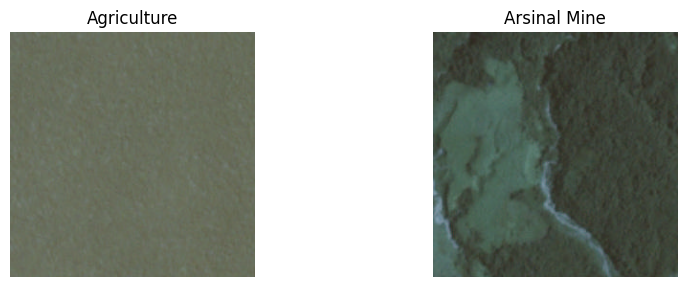

In [25]:
# create figure
fig = plt.figure(figsize=(10, 7))
# setting values to rows and column variables
rows = 2
columns = 2
Image1 = cv2.imread('planets-dataset/planet/planet/train-jpg/train_0.jpg')
Image2 = cv2.imread('planets-dataset/planet/planet/train-jpg/train_1.jpg')

fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Agriculture")
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Arsinal Mine")

y_train = np.array(train_df['tags'].tolist())

<Figure size 800x800 with 0 Axes>

conventional_mine is tagged least no of times: 99
primary is tagged max no of times: 37512


<BarContainer object of 17 artists>

([<matplotlib.axis.XTick at 0x7e05de634eb0>,
 [Text(0, 0, 'haze'),
  Text(1, 0, 'primary'),
  Text(2, 0, 'agriculture'),
  Text(3, 0, 'clear'),
  Text(4, 0, 'water'),
  Text(5, 0, 'habitation'),
  Text(6, 0, 'road'),
  Text(7, 0, 'cultivation'),
  Text(8, 0, 'slash_burn'),
  Text(9, 0, 'cloudy'),
  Text(10, 0, 'partly_cloudy'),
  Text(11, 0, 'conventional_mine'),
  Text(12, 0, 'bare_ground'),
  Text(13, 0, 'artisinal_mine'),
  Text(14, 0, 'blooming'),
  Text(15, 0, 'selective_logging'),
  Text(16, 0, 'blow_down')])

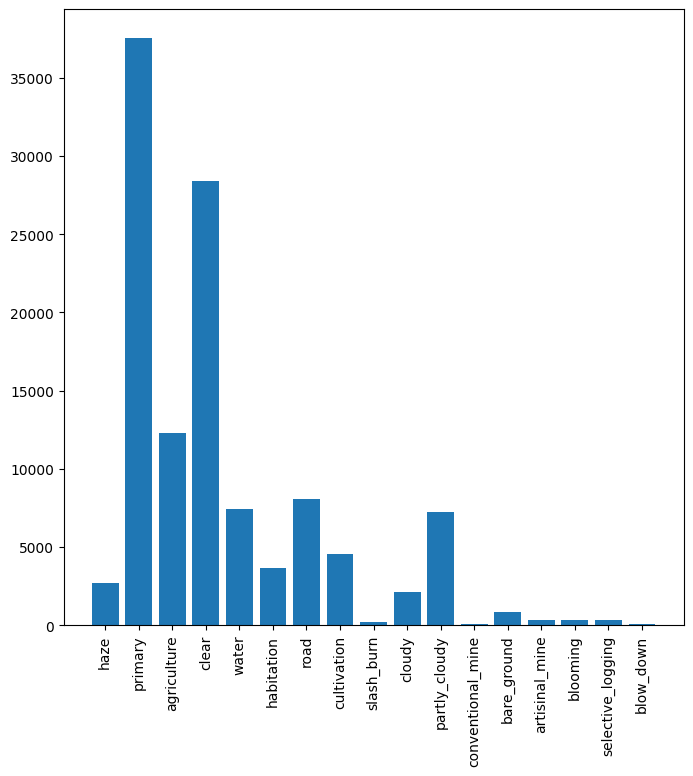

In [26]:
plt.figure(figsize=(8, 8))

labels_count = {}

for tag in train_df['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0

min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)
print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))

plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

In [27]:
def create_model():
    model = Sequential()
    model.add(InputLayer(INPUT_SHAPE))
    model.add(VGG16(weights='imagenet', include_top=False))
    model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(DROPOUT_RATE))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(17, activation='sigmoid'))
    return model

clear_session()

model = create_model()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 17)                139281    
                                                                 
Total params: 14,853,969
Trainable params: 14,853,969
Non-trainable params: 0
_________________________________________________________________


In [28]:
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [29]:
import gc
gc.collect()

973

In [ ]:
num_fold = 0

y_test = []

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])

    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])

    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=train_df,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )

    val_datagen = ImageDataGenerator(
        rescale=1./255
    )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=train_df,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255
    )

    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        directory=test_df,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
    )

    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')

    clear_session()
    model = create_model()

    adam = Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])

    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]

    model.fit_generator(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                       workers=WORKERS, use_multiprocessing=True, max_queue_size=MAXQ)

    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=WORKERS, use_multiprocessing=True, max_queue_size=MAXQ)
    y_test.append(p_test)